In [1]:
from collections import OrderedDict
from time import time
import re
import json
from natsort import natsorted
from glob import glob
from pathlib import Path
import os

import math
from random import random, shuffle, choice

# import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

import numpy as np
from scipy.spatial import Delaunay

from matplotlib import collections  as mc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from IPython.display import clear_output

nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, labels=False, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    return ax
#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




def subtree_sizes(tree, root):
    tree = nx.bfs_tree(tree, source=root)
    s = [len(nx.bfs_tree(tree, i).nodes) for i in tree.neighbors(root)]
    total = sum(s)
    return np.array(s)


def normalize(node):
    for prop in node:
        if prop == 'pos':
            pos = node[prop].replace('"', '')
            pos = pos.split(',')
            pos = [float(pos[0]), float(pos[1])]
            node[prop] = pos
        else:
            if type(node[prop]) == str:
                node[prop] = node[prop].replace('"', '')
                
            try:
                node[prop] = int(node[prop])
            except ValueError:
                try:
                    node[prop] = float(node[prop])
                except ValueError:
                    pass
            except Exception as err:
                print(err)
                print(node, prop)

                
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


## Choose a graph

In [2]:
##lastfm
# fns = natsorted(glob('./data/txt/lastfm/*.txt'))[:6]

##topics
# fns = natsorted(glob('./data/txt/topics_faryad_8level/*.txt'))
# fns = natsorted(glob('./data/txt/topics_faryad_5000/*.txt'))[:8]

##tree-of-life
# fns = [
#     f'./data/txt/tol_graphs/{fn}' for fn in 
#     [
#         'Graph_0.txt', 
#         'Graph_1.txt', 
#         'Graph_2_600.txt', 
#         'Graph_2.txt', 
#         'Graph_3.txt', 
#         'Graph_4_1600.txt', 
#         'Graph_4_2000.txt',
# #         'Graph_4.txt',
#     ]
# ]

# ##math_genealogy
# fns = [
#     f'./data/txt/math_genealogy/{fn}' for fn in 
#     [
#       'Graph_0.txt', 
#       'Graph_1.txt', 
#       'Graph_2_600.txt', 
#       'Graph_2.txt', 
#       'Graph_3_1200.txt', 
#       'Graph_3_1600.txt', 
#       'Graph_3_2000.txt', 
# #       'Graph_3.txt',
#     ]
# ]



levels = list(range(1, len(fns)+1))
maxLevel = max(*levels)


## linear increment
suffix = 'linear'
baseWeight = 200
if 'topics_steiner' in fns[0]:
    increment = 50
elif 'tol_graphs' in fns[0]:
    increment = 50
else:
    increment = 50
weights = [baseWeight+(maxLevel-l)*increment for l in levels]
weights = [w/baseWeight for w in weights]## normalize the weight to min=1


## exponential increment
# suffix = 'exp'
# baseWeight = 1
# maxWeight = 1
# incrementFactor = maxWeight**(1/(maxLevel-1))
# weights = [baseWeight*incrementFactor**(maxLevel-l) for l in levels]


print(f'level\tweight\tfile name')
for fn, level, weight in zip(fns ,levels, weights):
    print(f'{level:5}\t{weight:6.2f}\t{fn}')
# list(zip(fns,levels,weights))

level	weight	file name
    1	  2.50	./data/txt/math_genealogy/Graph_0.txt
    2	  2.25	./data/txt/math_genealogy/Graph_1.txt
    3	  2.00	./data/txt/math_genealogy/Graph_2_600.txt
    4	  1.75	./data/txt/math_genealogy/Graph_2.txt
    5	  1.50	./data/txt/math_genealogy/Graph_3_1200.txt
    6	  1.25	./data/txt/math_genealogy/Graph_3_1600.txt
    7	  1.00	./data/txt/math_genealogy/Graph_3_2000.txt


In [3]:
print(f'{"level":5} {"nodeCount":9} {"weight":6} {"file name"}')

for i, (fn, level, weight) in list(enumerate(zip(fns, levels, weights)))[::-1]:
    with open(fn) as f:
        if level == maxLevel:
            subgraph, i2k, label2i = edges2graph(f.readlines())
            g = subgraph
        else:
            subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        nodeCount = len(subgraph)
        print(f'{level:5} {nodeCount:9} {weight:6.2f} {fn}')
    
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            g.nodes[n]['nodeCount'] = nodeCount
            g.nodes[n]['weight'] = weight

        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = weight


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for source, target_dists in tqdm(apsp):
    d[source,:] = [target_dists[i] for i in range(len(g.nodes))]
    

print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for source, target_dists in tqdm(apsp):
    hops[source,:] = [target_dists[i] for i in range(len(g.nodes))]

fn = fns[-1]

level nodeCount weight file name
    7      2001   1.00 ./data/txt/math_genealogy/Graph_3_2000.txt
    6      1601   1.25 ./data/txt/math_genealogy/Graph_3_1600.txt
    5      1201   1.50 ./data/txt/math_genealogy/Graph_3_1200.txt
    4       880   1.75 ./data/txt/math_genealogy/Graph_2.txt
    3       601   2.00 ./data/txt/math_genealogy/Graph_2_600.txt
    2       152   2.25 ./data/txt/math_genealogy/Graph_1.txt
    1        31   2.50 ./data/txt/math_genealogy/Graph_0.txt
all_pairs_shortest_path...


0it [00:00, ?it/s]

k-hop all_pairs_shortest_path...


0it [00:00, ?it/s]

## Initial Layout

In [4]:
def fan(nodes, 
        origin=[0,0], radii=[], 
        phaseCenter=0, phaseRange=np.pi, 
        weights=[1,1], 
        mode='random'):
    pos = {}
    phases = {}
    ranges = {}
    n = len(nodes)
    cos, sin = np.cos, np.sin
    
    weightTotal = sum(weights)
    weights = [w/weightTotal for w in weights]
    
    nr = sorted(zip(nodes, weights, radii), key=lambda x:x[1])
    
    
    if mode == 'center':
        ## centralize heavy sub trees
        nr2 = []
        for i in list(range(len(nr)))[::-1]:
            if i%2 == 0:
                nr2.append(nr[i])
            else:
                nr2.insert(0, nr[i])
    elif mode == 'polar':
        ## polarize heavy sub trees
        nr2 = []
        for i in range(len(nr)):
            if i%2 == 0:
                nr2.append(nr[i])
            else:
                nr2.insert(0, nr[i])
    elif mode == 'random':
        shuffle(nr)
        nr2 = nr
    elif mode == 'interleave':
        a = nr[::2]
        b = nr[1::2][::-1]
        if len(a)==len(b):
            nr2 = sum(zip(a,b), tuple())
        else:
            nr2 = sum(zip(a,b+[-1,]), tuple())[:-1]
            
    elif mode == 'ordered':
        nr2 = nr
        
    nodes, weights, radii = zip(*nr2)
    
    weightCumSum = [sum(weights[:i]) for i in range(len(weights)+1)]
    for i in range(n):
        angle_offset = (weightCumSum[i]+weightCumSum[i+1])/2 * phaseRange
        angle_i = phaseCenter - phaseRange/2 + angle_offset
        ri = radii[i]
        pos[nodes[i]] = [origin[0] + ri*cos(angle_i), origin[1] + ri*sin(angle_i)]
        phases[nodes[i]] = angle_i
        ranges[nodes[i]] = weights[i] * phaseRange * 0.9
    return pos, phases, ranges


def radial_layout(g, root=None, mode='center', origin=[0,0], phase0=0, range0=np.pi*2):
    g0 = g
    g = nx.bfs_tree(g, source=root)
    pos = {}
    phases = {}
    ranges = {}
    depth_from_root = nx.shortest_path_length(g, root)
    if root is None:
        root = next(iter(g.nodes))
    pos[root] = origin
    phases[root] = phase0
    ranges[root] = range0
    roots = [root, ]
    depth = 1
    while len(pos) < len(g.nodes):
        newRoots = []
        for root in roots:
            if mode=='ordered':
                neighbors = [n for n in g0.nodes[root]['neighbor_order'] if n not in pos]
            else:
                neighbors = [n for n in g.neighbors(root) if n not in pos]
            if len(neighbors) > 0:
                edge_lengths = [g0.edges[(root, n)]['weight'] for n in neighbors]
                subTreeSizes = [len(nx.bfs_tree(g, i).nodes) for i in neighbors]
                degrees = [g.degree[i] for i in neighbors]
                depths = [depth_from_root[i] for i in neighbors]
#                 weights = [(x*z/y**2) for x, y, z in zip(degrees, depths, subTreeSizes)]
                weights = [z for x, y, z in zip(degrees, depths, subTreeSizes)]
#                 neighborSizes = [len(list(g0.neighbors(i))) for i in neighbors]
                newRoots += neighbors
                newPos, newPhases, newRanges = fan(
                    neighbors, 
                    mode=mode,
#                     origin=pos[root], radii=edge_lengths, #mode: Reyan
                    origin=origin, radii=[depth for e in edge_lengths],#mode: mw
                    phaseCenter=phases[root], 
                    phaseRange=ranges[root], 
                    weights=weights,
                )
                pos.update(newPos)
                phases.update(newPhases)
                ranges.update(newRanges)
        roots = newRoots
        depth+=1
    return pos


def rotate(pos0, theta=0):
    cos = math.cos(theta)
    sin = math.sin(theta)
    pos = {}
    for k in pos0:
        p = pos0[k]
        pos[k] = (p[0]*cos-p[1]*sin, p[0]*sin+p[1]*cos)
    return pos



def neighbor_order(nodeId, parentId, neighbors, pos):
    v = np.array([pos[i] for i in neighbors]) - np.array([pos[nodeId]])
    a = np.angle(v[:,0] + 1j * v[:,1])
    order = [neighbors[o] for o in np.argsort(a)]
    if parentId is not None:
        order = np.roll(order, -order.index(parentId))
    return order


2.8931684494018555 sec


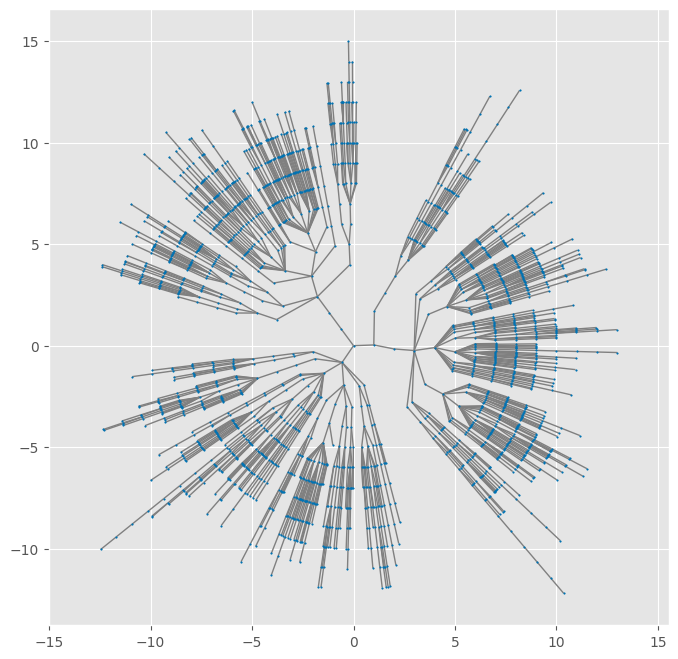

In [5]:
# %%time

init_layout = 'radial'
# init_layout = 'sfdp-ordered-radial'
# init_layout = 'sfdp'

# # pos0 = nx.layout.planar_layout(g, scale=40)
# # pos0 = graphviz_layout(g, prog="dot", root=list(g.nodes)[0])
# # pos0 = graphviz_layout(g, prog='twopi')

t0 = time()
if init_layout == 'sfdp':
    g1 = nx.Graph(g)
    for i in g1.nodes:
        g1.nodes[i]['label'] = ''
    pos0 = graphviz_layout(g1, prog='sfdp')
    
    
elif init_layout == 'radial':
#     root = list(g.nodes)[np.argmin(hops.max(axis=1))] ##large-depth node
# #     root = list(g.nodes)[np.argmin(d.max(axis=1))] ##large-depth node
# #     root = choice(list(g.nodes)) ##random node
# #     root = nx.center(g)[0]
#     if 'tol_graphs/Graph_4.txt' in fn:
#         root = 1949 ##tree-of-life 3000-nodes
# #     root = 1143
    root = nx.center(g)[0]
    pos0 = radial_layout(g, root, mode='center')


elif init_layout == 'sfdp-ordered-radial':
    
    ##remove label to avoid parsing bug of sfdp
    g1 = nx.Graph(g)
    for i in g1.nodes:
        g1.nodes[i]['label'] = '' 
    pos_sfdp = graphviz_layout(g1, prog='sfdp')
    draw(g, pos_sfdp, s=1, lw=1, labels=False, figsize=[8,8])
#     center = np.array(list(pos_sfdp.values())).mean(0)
#     root = min([p for p in pos_sfdp.items()], key=lambda x:np.linalg.norm(x[1]-center))[0]
    root = list(g.nodes)[np.argmin(d.max(axis=1))] ##large-depth node
#     root = 1949 ##tree-of-life 3000-nodes
#     root = nx.center(g)[0]
    bfs = nx.bfs_tree(g, root)
    for nodeId in g:
        try:
            parentId = next(bfs.predecessors(nodeId))
        except StopIteration:
            parentId = None
        neighbors = list(g.neighbors(nodeId))
        g.nodes[nodeId]['neighbor_order'] = neighbor_order(nodeId, parentId, neighbors, pos_sfdp)
    pos0 = radial_layout(g, root, mode='ordered')
    


dt = time() - t0
print(f'{dt} sec')

rot = 0
pos0 = rotate(pos0, math.pi/180*rot)
draw(g, pos0, s=1, lw=1, labels=False, figsize=[8,8])
plt.show()

## New Ordering of Nodes

In [6]:
node_order = list(g.nodes)
bfs = nx.bfs_tree(g, root)

### list of node ids


# if ('math-genealogy' in fn 
#     or 'topics-800' in fn
#     or 'covid' in fn
#    ):
    
# print('no re-ordering')
## no re-ordering
# node_order = list(g.nodes)

## order preserving re-sort according to level
# id2level = {i: g.nodes[i]['level'] for i in g.nodes}
# nodeorder_level_pairs = [(i,id2level[i]) for i in node_order]
# node_order = [n[0] for n in sorted(nodeorder_level_pairs, key=lambda x:x[1])]

##bfs ordering
print('bfs ordering')
node_order = list(bfs) 



# else:
#     #max degree node
#     print('max degree node re-ordering')
#     degree = list(g.degree)
#     degree = list(zip(range(len(degree)), degree))
#     max_degree_node = max(degree, key=lambda x:x[1][1])
#     start = max_degree_node[1][0]
#     bfs = nx.bfs_tree(g, start)
#     node_order = list(bfs) 
    
# #     # random node, bfs
# #     start = next(iter(g.nodes.keys()))
# #     bfs = nx.bfs_tree(g, start)
# #     node_order = list(bfs) 

# #     #dfs
# #     node_order = list(nx.dfs_preorder_nodes(g, start))





bfs ordering


## Scaling inital layout

In [7]:
## scaling that minimizes desired-edge-length criteria

# pos = pos0.copy()
# ideal_edge_length = {
#     e: g.edges[e]['weight'] 
#     for e in g.edges
# }
# actual_edge_length = {
#     (p0,p1): np.linalg.norm(np.array(pos[p1])-np.array(pos[p0]))
#     for (p0,p1) in g.edges
# }
# num = np.sum([ideal_edge_length[k]*actual_edge_length[k] for k in g.edges])
# den = np.sum([actual_edge_length[k]**2 for k in g.edges])
# s = num / den
# print(f's = {s}')

# pos = {k:np.array(v)*s for k,v in pos.items()}

In [8]:
## scaling so that actual_edge_lengths >= desired_edge_lengths

def dist(p0, p1):
    v = np.array(p1) - np.array(p0)
    return np.linalg.norm(v)


desired_edge_lengths = {(e0,e1):data['weight'] for e0,e1,data in g.edges(data=True)}
actual_edge_lengths = {(e0,e1):dist(pos0[e0],pos0[e1]) for e0,e1,data in g.edges(data=True)}

actual_desire_ratio = {(e0, e1): actual_edge_lengths[e0,e1] / desired_edge_lengths[e0,e1] for e0,e1 in desired_edge_lengths}
min_ratio = np.min(list(actual_desire_ratio.values()))

s = 1/min_ratio
pos = {k:list(np.array(v)*s) for k,v in pos0.items()}
s

2.5000000000000027

## to JSON

In [9]:
dir_out, name = str(Path(fn).parent), Path(fn).stem
dir_out = dir_out.replace('dot', 'json').replace('txt', 'json')
dir_out += f'_{suffix}'
fn_out = dir_out + '/'+ name
fn_out += f'-{int(time())}'

if not Path(dir_out).exists():
    os.makedirs(Path(dir_out))
else:
    print(Path(dir_out), 'exists')
fn_out

data/json/math_genealogy_linear exists


'data/json/math_genealogy_linear/Graph_3_2000-1667445712'

In [10]:
for n in g.nodes:
    if 'neighbor_order' in g.nodes[n]:
        del g.nodes[n]['neighbor_order']
    else:
        break

In [11]:
###graph to list
nodes = {k: g.nodes[k] for k in g.nodes}
edges = [[e[0], e[1], g.edges[e]] for e in g.edges]

nodes = [{
    'id': node_order[i],
    'index': i,
    'x': float(pos[node_order[i]][0]),
    'y': float(pos[node_order[i]][1]),
    'neighbors': list(nx.neighbors(g, node_order[i])),
    'perplexity': len(list(nx.neighbors(g, node_order[i]))),
    **nodes[node_order[i]]
} for i in range(len(nodes))]

edges = [{
    'source': e[0],
    'target': e[1],
    **e[2]
} for e in edges]



##store the position & perplexity
for i,node in enumerate(nodes):
    try: 
        parent = next(bfs.predecessors(node['id']))
    except StopIteration:
        parent = None
    node['parent'] = parent

hopMin = 5
hopMax = 4
sampleRate = 0.1
virtual_edges = []
for i in tqdm(range(len(nodes))):
    for j in range(i+1, len(nodes)):
        if d[i,j] == 0:
            print(f'[warning] d[{i},{j}] = 0')
        else:
            if (hops[i,j] >= hopMin 
                and hops[i,j] <= hopMax 
                or random() < sampleRate
            ):
                dij = d[i,j]
                e = {
                    'source': i2k[i],
                    'target': i2k[j],
                    'weight': dij,
                    'hops': hops[i,j]
                }
                virtual_edges.append(e)
            else:
                continue
            

## option 2: properties as arrays
res = {}
for k in nodes[0]:
    print(k)
    res[f'node_{k}'] = [n[k] for n in nodes]
for k in edges[0]:
    res[f'edge_{k}'] = [e[k] for e in edges]

print(fn_out)
with open(fn_out+'-min.json', 'w') as f:
    json.dump(res, f, indent=2)
    
for k in virtual_edges[0]:
    res[f'virtual_edge_{k}'] = [ve[k] for ve in virtual_edges]

print(f'writing to:\n\t{fn_out}.json\n...')
with open(fn_out+'.json', 'w') as f:
    json.dump(res, f, indent=2)

print('done!')




  0%|          | 0/2001 [00:00<?, ?it/s]

id
index
x
y
neighbors
perplexity
label
level
nodeCount
weight
parent
data/json/math_genealogy_linear/Graph_3_2000-1667445712
writing to:
	data/json/math_genealogy_linear/Graph_3_2000-1667445712.json
...
done!


---